In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..'))) # To import keras_squeezenet.
from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import keras.utils as image

ImportError: cannot import name '_obtain_input_shape' from 'keras.applications.imagenet_utils' (D:\Programs\Conda\lib\site-packages\keras\applications\imagenet_utils.py)

In [3]:
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [6]:
dataset_url = "../Dataset/Cropped"

import pathlib
data_dir = pathlib.Path(dataset_url)
data_dir

WindowsPath('../Dataset/Cropped')

In [7]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('../Dataset/Cropped/Abnormal-Heartbeat/HB(1).jpg'),
 WindowsPath('../Dataset/Cropped/Abnormal-Heartbeat/HB(10).jpg'),
 WindowsPath('../Dataset/Cropped/Abnormal-Heartbeat/HB(100).jpg'),
 WindowsPath('../Dataset/Cropped/Abnormal-Heartbeat/HB(101).jpg'),
 WindowsPath('../Dataset/Cropped/Abnormal-Heartbeat/HB(102).jpg')]

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

928


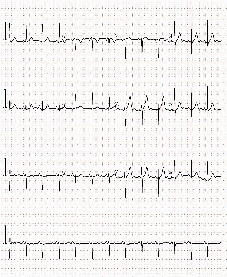

In [9]:
import PIL
PIL.Image.open(str(list(data_dir.glob('Normal/*'))[0]))

In [10]:
ecg_dict = {
    'normal': list(data_dir.glob('Normal/*')),
    'abnormal': list(data_dir.glob('Abnormal-Heartbeat/*')),
    'hist': list(data_dir.glob('History-Myocardial-Infarction/*')),
    'myco': list(data_dir.glob('Myocardial-Infarction/*')),
}

In [11]:
ecg_labels_dict = {
    'normal':0,
    'abnormal':1,
    'hist':2,
    'myco':3,
}

In [12]:
import cv2
img = cv2.imread(str(ecg_dict['normal'][0]))
img.shape

(277, 227, 3)

In [13]:
X, y = [], []

for label, images in ecg_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(227,227))
        X.append(resized_img)
        y.append(ecg_labels_dict[label])

In [14]:
X = np.array(X)
y = np.array(y)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=0)

In [19]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [20]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

<h1>Weights pretrained over ImageNet</h1>
<p>Check to make sure we can get the pretrained weights. The weights should have some structure, and the classification should be pretty good, since the model is already trained.</p>

In [25]:
base_model = SqueezeNet(weights='imagenet')

In [26]:
# This is the full model layers.
base_model.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 113, 113, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 relu_conv1 (Activation)        (None, 113, 113, 64  0           ['conv1[0][0]']                  
                                )                                                        

 on)                                                                                              
                                                                                                  
 fire5/concat (Concatenate)     (None, 27, 27, 256)  0           ['fire5/relu_expand1x1[0][0]',   
                                                                  'fire5/relu_expand3x3[0][0]']   
                                                                                                  
 pool5 (MaxPooling2D)           (None, 13, 13, 256)  0           ['fire5/concat[0][0]']           
                                                                                                  
 fire6/squeeze1x1 (Conv2D)      (None, 13, 13, 48)   12336       ['pool5[0][0]']                  
                                                                                                  
 fire6/relu_squeeze1x1 (Activat  (None, 13, 13, 48)  0           ['fire6/squeeze1x1[0][0]']       
 ion)     

                                                                                                  
 relu_conv10 (Activation)       (None, 13, 13, 1000  0           ['conv10[0][0]']                 
                                )                                                                 
                                                                                                  
 global_average_pooling2d_2 (Gl  (None, 1000)        0           ['relu_conv10[0][0]']            
 obalAveragePooling2D)                                                                            
                                                                                                  
 loss (Activation)              (None, 1000)         0           ['global_average_pooling2d_2[0][0
                                                                 ]']                              
                                                                                                  
Total para

In [27]:
base_model = Model(inputs=base_model.input, outputs=base_model.layers[-3].output)

In [28]:
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 113, 113, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 relu_conv1 (Activation)        (None, 113, 113, 64  0           ['conv1[0][0]']                  
                                )                                                           

 on)                                                                                              
                                                                                                  
 fire5/concat (Concatenate)     (None, 27, 27, 256)  0           ['fire5/relu_expand1x1[0][0]',   
                                                                  'fire5/relu_expand3x3[0][0]']   
                                                                                                  
 pool5 (MaxPooling2D)           (None, 13, 13, 256)  0           ['fire5/concat[0][0]']           
                                                                                                  
 fire6/squeeze1x1 (Conv2D)      (None, 13, 13, 48)   12336       ['pool5[0][0]']                  
                                                                                                  
 fire6/relu_squeeze1x1 (Activat  (None, 13, 13, 48)  0           ['fire6/squeeze1x1[0][0]']       
 ion)     

                                                                                                  
 relu_conv10 (Activation)       (None, 13, 13, 1000  0           ['conv10[0][0]']                 
                                )                                                                 
                                                                                                  
Total params: 1,235,496
Trainable params: 1,235,496
Non-trainable params: 0
__________________________________________________________________________________________________


In [29]:
# for layer in base_model.layers:
#     layer.trainable = False

In [30]:
x = layers.Conv2D(4, (1, 1), activation='relu')(base_model.output)

# Global Average Pooling to reduce spatial dimensions
x = layers.GlobalAveragePooling2D()(x)

# New classification layer with softmax activation for 4 classes
outputs = layers.Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input,outputs=outputs)

In [31]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 113, 113, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 relu_conv1 (Activation)        (None, 113, 113, 64  0           ['conv1[0][0]']                  
                                )                                                           

 on)                                                                                              
                                                                                                  
 fire5/concat (Concatenate)     (None, 27, 27, 256)  0           ['fire5/relu_expand1x1[0][0]',   
                                                                  'fire5/relu_expand3x3[0][0]']   
                                                                                                  
 pool5 (MaxPooling2D)           (None, 13, 13, 256)  0           ['fire5/concat[0][0]']           
                                                                                                  
 fire6/squeeze1x1 (Conv2D)      (None, 13, 13, 48)   12336       ['pool5[0][0]']                  
                                                                                                  
 fire6/relu_squeeze1x1 (Activat  (None, 13, 13, 48)  0           ['fire6/squeeze1x1[0][0]']       
 ion)     

                                                                                                  
 relu_conv10 (Activation)       (None, 13, 13, 1000  0           ['conv10[0][0]']                 
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 13, 13, 4)    4004        ['relu_conv10[0][0]']            
                                                                                                  
 global_average_pooling2d_3 (Gl  (None, 4)           0           ['conv2d_1[0][0]']               
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_1 (Dense)                (None, 4)            20          ['global_average_pooling2d_3[0][0
          

In [32]:
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(X_train_scaled, y_train_one_hot, epochs=20)

Epoch 1/20
22/22 [==============================] - 41s 2s/step - loss: 1.2772 - accuracy: 0.3348
Epoch 2/20
22/22 [==============================] - 38s 2s/step - loss: 1.2535 - accuracy: 0.3750
Epoch 3/20
22/22 [==============================] - 38s 2s/step - loss: 1.2119 - accuracy: 0.3922
Epoch 4/20
22/22 [==============================] - 39s 2s/step - loss: 1.1759 - accuracy: 0.4382
Epoch 5/20
22/22 [==============================] - 38s 2s/step - loss: 1.2230 - accuracy: 0.4828
Epoch 6/20
22/22 [==============================] - 38s 2s/step - loss: 1.1393 - accuracy: 0.4828
Epoch 7/20
22/22 [==============================] - 36s 2s/step - loss: 1.1039 - accuracy: 0.4741
Epoch 8/20
22/22 [==============================] - 36s 2s/step - loss: 1.0899 - accuracy: 0.5043
Epoch 9/20
22/22 [==============================] - 37s 2s/step - loss: 1.1047 - accuracy: 0.5172
Epoch 10/20
22/22 [==============================] - 37s 2s/step - loss: 1.1032 - accuracy: 0.5273
Epoch 11/20
22/22 [

In [ ]:
predictions = model.predict(X_test)

In [ ]:
accuracy = model.evaluate(X_test, y_test)[1]

In [ ]:
max_indices = np.argmax(predictions, axis=1)
preds = np.zeros_like(predictions)
preds[np.arange(predictions.shape[0]), max_indices] = 1

In [ ]:
precision = precision_score(y_test, preds, average='weighted')
recall = recall_score(y_test, preds, average='weighted')
f1 = f1_score(y_test, preds, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
inp = '../data/Abnormal-Heartbeat/HB(10).jpg'
i = cv2.imread(str(inp))
ri = cv2.resize(img,(227,227))
ri = np.expand_dims(ri, axis=0)
ri = np.array(ri)
ri_= ri/255.0

In [ ]:
pred = model.predict(ri_)
idx = np.argmax(pred, axis=1)[0]
ecg_labels_dict[idx]